# VGG

This notebook uses model "VGG16" to conduct regression of images.

In [1]:
import h5py
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torchvision import models

## Step 1 - Config

First set the hyperparameters and other configurations.

In [2]:
# Dataset and model path
DATASET_PATH = "./datasets/Ra_128_indexed.h5"
MODEL_DIR = "./models"
OUTPUT_DIR = "./outputs"
# Env
SEED = 42
# Dataset
MIN_LABEL = 1.3
MAX_LABEL = 5.2
# Hyperparameters
NUM_EPOCHS = 10
LR = 1e-3
LR_WEIGHT_DECAY = 1e-4
TEST_SIZE = 0.5
BATCH_SIZE_TRAIN = 256
BATCH_SIZE_VAL = 10

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# Path
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR, exist_ok=True)
    print(f"Make new directory {MODEL_DIR}")
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    print(f"Make new directory {OUTPUT_DIR}")
MODEL_PATH = f"{MODEL_DIR}/VGG16_test_size_{TEST_SIZE}_epoch_{NUM_EPOCHS}_batch_size_{BATCH_SIZE_TRAIN}_lr_{LR:.0e}_seed_{SEED}.pth"
OUTPUT_PATH = f"{OUTPUT_DIR}/VGG16_test_size_{TEST_SIZE}_epoch_{NUM_EPOCHS}_batch_size_{BATCH_SIZE_TRAIN}_lr_{LR:.0e}_seed_{SEED}.csv"

Device: cuda


Then load the pretrained model from `torchvision`.

In [3]:
# Pretrained VGG16 model
vgg16 = models.vgg16(pretrained=True)

# Change the last layer to fit the regression task
vgg16.classifier[-1] = nn.Linear(in_features=4096, out_features=1)

# Choose to freeze the layers or not
for param in vgg16.features.parameters():
    param.requires_grad = False

# Move to the appropriate device
vgg16 = vgg16.to(device)

/opt/pytorch/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/pytorch/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Step 2 - Load data

In this step we load the images and process them, the goal is to get `train_loader` and `val_loader` for training. After this step we will get:

1. `images_train` and `images_val` (4 dim tensor)
2. `labels_train` and `labels_val` (1 dim tensor)
3. `train_dataset` and `val_dataset` (dataset)
4. `train_loader` and `val_loader` (dataloader)

First we load the images (`images`) and labels (`labels`).

In [4]:
# Load datasets
with h5py.File(DATASET_PATH, "r") as f:
    images = f["images"][:].astype(float)
    labels = f["labels"][:].astype(float)
N_all = len(images)
print("Images and labels loaded.")
print(f"Images Shape: {images.shape}")
print(f"Labels Shape: {labels.shape}")
print("")

# Selection
indx = np.where((labels >= MIN_LABEL) * (labels < MAX_LABEL) == True)[0]
labels = labels[indx]
images = images[indx]
print(f"Select indexes by MIN_LABEL = {MIN_LABEL} and MAX_LABEL = {MAX_LABEL}")
print(f"Images Shape: {images.shape}")
print(f"Labels Shape: {labels.shape}")
print("")

# To tensor
images = torch.from_numpy(images).permute(0, 3, 1, 2)
labels = torch.from_numpy(labels)
print("Transform `images` and `labels` to tensors.")
print(f"Images Shape: {images.shape}")
print(f"Labels Shape: {labels.shape}")

Images and labels loaded.
Images Shape: (9192, 128, 128, 3)
Labels Shape: (9192,)

Select indexes by MIN_LABEL = 1.3 and MAX_LABEL = 5.2
Images Shape: (9192, 128, 128, 3)
Labels Shape: (9192,)

Transform `images` and `labels` to tensors.
Images Shape: torch.Size([9192, 3, 128, 128])
Labels Shape: torch.Size([9192])


Then use `train_test_split` function to get data for training and validation.

In [5]:
# Train-test split
images_train, images_val, labels_train, labels_val = train_test_split(
    images, labels, test_size=TEST_SIZE, random_state=SEED
)

Implement images standardization and labels normalization.

In [6]:
# Image standardization
mean = images_train.mean(dim=[0, 2, 3], keepdim=True)
std = images_train.std(dim=[0, 2, 3], keepdim=True)
print(f"Mean of `images_train`: {mean}")
print(f"Std of `images_train`: {std}")
images_train = (images_train - mean) / std
images_val = (images_val - mean) / std

# Label normalization
labels_train = (labels_train - MIN_LABEL) / (MAX_LABEL - MIN_LABEL)
labels_val = (labels_val - MIN_LABEL) / (MAX_LABEL - MIN_LABEL)

print(f"Train test split with test size {TEST_SIZE}.")
print(f"Images (train) Shape: {images_train.shape}")
print(f"Images (val) Shape: {images_val.shape}")
print(f"Labels (train) Shape: {labels_train.shape}")
print(f"Labels (val) Shape: {labels_val.shape}")

Mean of `images_train`: tensor([[[[ 13.6506]],

         [[ 17.8427]],

         [[112.0481]]]], dtype=torch.float64)
Std of `images_train`: tensor([[[[18.6748]],

         [[20.2556]],

         [[41.5851]]]], dtype=torch.float64)
Train test split with test size 0.5.
Images (train) Shape: torch.Size([4596, 3, 128, 128])
Images (val) Shape: torch.Size([4596, 3, 128, 128])
Labels (train) Shape: torch.Size([4596])
Labels (val) Shape: torch.Size([4596])


Next, we should transform the data to tensors, combine `images` and `labels` to datasets and get dataloaders according to `BATCH_SIZE`.

In [7]:
# Change to tensor
images_train_tensor = torch.tensor(images_train, dtype=torch.float32)
images_val_tensor = torch.tensor(images_val, dtype=torch.float32)
labels_train_tensor = torch.tensor(labels_train, dtype=torch.float32).view(-1, 1)
labels_val_tensor = torch.tensor(labels_val, dtype=torch.float32).view(-1, 1)
print(f"Shape of `images_train_tensor`: {images_train_tensor.shape}")
print(f"Shape of `labels_train_tensor`: {labels_train_tensor.shape}")
print(f"Shape of `images_val_tensor`: {images_val_tensor.shape}")
print(f"Shape of `labels_val_tensor`: {labels_val_tensor.shape}")

# Tensor's dataset
train_dataset = TensorDataset(images_train_tensor, labels_train_tensor)
val_dataset = TensorDataset(images_val_tensor, labels_val_tensor)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE_TRAIN, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE_VAL)

/tmp/ipykernel_21772/1722485521.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images_train_tensor = torch.tensor(images_train, dtype=torch.float32)
/tmp/ipykernel_21772/1722485521.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images_val_tensor = torch.tensor(images_val, dtype=torch.float32)


Shape of `images_train_tensor`: torch.Size([4596, 3, 128, 128])
Shape of `labels_train_tensor`: torch.Size([4596, 1])
Shape of `images_val_tensor`: torch.Size([4596, 3, 128, 128])
Shape of `labels_val_tensor`: torch.Size([4596, 1])


/tmp/ipykernel_21772/1722485521.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_train_tensor = torch.tensor(labels_train, dtype=torch.float32).view(-1, 1)
/tmp/ipykernel_21772/1722485521.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_val_tensor = torch.tensor(labels_val, dtype=torch.float32).view(-1, 1)


## Step 3 - Train

Start training for `epoch` loops, record the training losses and validation losses.

In [8]:
# Criterion and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(
    vgg16.classifier.parameters(), lr=LR, weight_decay=LR_WEIGHT_DECAY
)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=5
)

# Record the loss values
train_loss_list = []
val_loss_list = []

# Loop by epoch
for epoch in range(NUM_EPOCHS):

    # Train
    vgg16.train()
    train_loss = 0.0
    train_size = 0
    for batch_images, batch_labels in train_loader:
        # Load data
        batch_images = batch_images.to(device)
        batch_labels = batch_labels.to(device)
        # Pass loss value
        outputs = vgg16(batch_images)
        loss = criterion(outputs, batch_labels)
        # Back propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Add to the total loss
        batch_size = batch_images.size(0)
        train_loss += loss.item() * batch_size
        train_size += batch_size

    train_loss = train_loss / train_size
    train_loss_list.append(train_loss)

    # Validate
    vgg16.eval()
    val_loss = 0
    val_samples = 0
    with torch.no_grad():
        for batch_images, batch_labels in val_loader:
            # Load data
            batch_images = batch_images.to(device)
            batch_labels = batch_labels.to(device)
            # Output
            outputs = vgg16(batch_images)
            # Calculate loss
            loss = criterion(outputs, batch_labels)
            # Add to total loss
            batch_size = batch_images.size(0)
            val_loss += loss.item() * batch_size
            val_samples += batch_size
    val_loss /= val_samples
    val_loss_list.append(val_loss)

    # Print
    print(
        f"[Epoch {(epoch+1):d} / {(NUM_EPOCHS):d}] [Train Loss {train_loss:f} (MSE)] [Valid Loss {val_loss:f} (MSE)] [Learning Rate: {optimizer.param_groups[0]['lr']}]"
    )

    # Scheduler
    scheduler.step(val_loss)

[Epoch 1 / 10] [Train Loss 2.356644 (MSE)] [Valid Loss 0.063842 (MSE)] [Learning Rate: 0.001]
[Epoch 2 / 10] [Train Loss 0.178717 (MSE)] [Valid Loss 0.056522 (MSE)] [Learning Rate: 0.001]
[Epoch 3 / 10] [Train Loss 0.067176 (MSE)] [Valid Loss 0.046281 (MSE)] [Learning Rate: 0.001]
[Epoch 4 / 10] [Train Loss 0.063373 (MSE)] [Valid Loss 0.031190 (MSE)] [Learning Rate: 0.001]
[Epoch 5 / 10] [Train Loss 0.048507 (MSE)] [Valid Loss 0.023035 (MSE)] [Learning Rate: 0.001]
[Epoch 6 / 10] [Train Loss 0.051011 (MSE)] [Valid Loss 0.038140 (MSE)] [Learning Rate: 0.001]
[Epoch 7 / 10] [Train Loss 0.045955 (MSE)] [Valid Loss 0.027874 (MSE)] [Learning Rate: 0.001]
[Epoch 8 / 10] [Train Loss 0.063648 (MSE)] [Valid Loss 0.028997 (MSE)] [Learning Rate: 0.001]
[Epoch 9 / 10] [Train Loss 0.043315 (MSE)] [Valid Loss 0.021322 (MSE)] [Learning Rate: 0.001]
[Epoch 10 / 10] [Train Loss 0.038826 (MSE)] [Valid Loss 0.020292 (MSE)] [Learning Rate: 0.001]


Then we plot the graphs of `train_loss_list` and `val_loss_lost`.

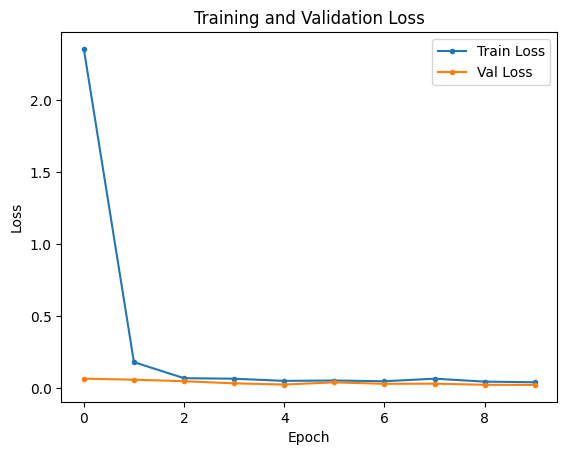

In [9]:
x = list(range(NUM_EPOCHS))
plt.plot(x, train_loss_list, label="Train Loss", marker=".")
plt.plot(x, val_loss_list, label="Val Loss", marker=".")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

## Step 4 - Save / load the model

After training, we need to save the models.

In [10]:
# Save the trained model to disk
torch.save(vgg16.state_dict(), MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")

Model saved to ./models/VGG16_test_size_0.5_epoch_10_batch_size_256_lr_1e-03_seed_42.pth


To read the saved data, we can run the following codes:

In [11]:
# # Load the trained model weights
# vgg16.load_state_dict(torch.load(MODEL_PATH, map_location=device))
# vgg16.eval()
# print("Model loaded from", MODEL_PATH)

## Exceptional test

Let's see if the model works well.

Model loaded from ./models/VGG16_test_size_0.5_epoch_10_batch_size_256_lr_1e-03_seed_42.pth
      Real Labels  Predicted Labels      Diff      MAPE
0           1.746          2.013458  0.267458  0.846817
1           2.695          2.546810 -0.148190  0.945013
2           1.816          2.019623  0.203623  0.887873
3           2.354          2.278820 -0.075180  0.968063
4           3.901          2.979115 -0.921885  0.763680
...           ...               ...       ...       ...
4591        3.492          2.909087 -0.582913  0.833072
4592        2.895          2.193072 -0.701928  0.757538
4593        2.860          2.775787 -0.084213  0.970555
4594        3.956          3.229743 -0.726257  0.816416
4595        2.203          2.074244 -0.128756  0.941554

[4596 rows x 4 columns]
MAPE: 0.848003849064232


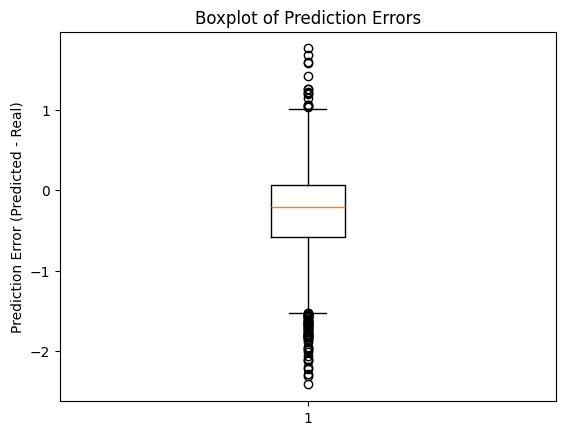

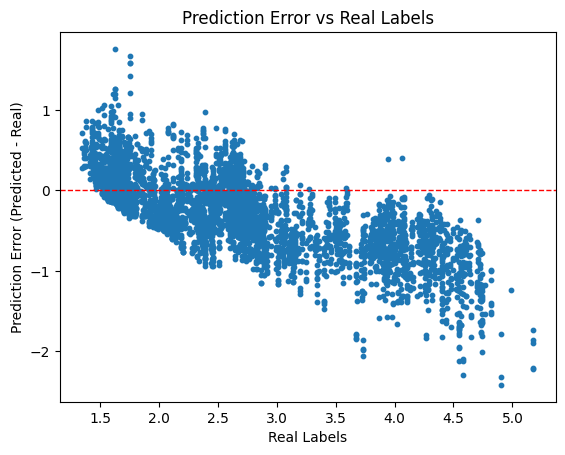

: 

In [ ]:
# Load the trained model weights
vgg16.load_state_dict(torch.load(MODEL_PATH, map_location=device))
vgg16.eval()
print("Model loaded from", MODEL_PATH)

# Turn to `numpy.array`
labels_val_real = labels_val.numpy()
labels_val_predicted = []
for _images_val_tensor, _labels_val_tensor in val_loader:
    preds = vgg16(_images_val_tensor.to(device)).cpu().detach().numpy()
    labels_val_predicted.append(preds)
labels_val_predicted = np.concatenate(labels_val_predicted, axis=0)

# Unnormalize labels
labels_val_real = labels_val_real * (MAX_LABEL - MIN_LABEL) + MIN_LABEL
labels_val_predicted = labels_val_predicted * (MAX_LABEL - MIN_LABEL) + MIN_LABEL

# Turn to `pandas.Series`
labels_val_real = pd.Series(labels_val_real)
labels_val_predicted = pd.Series(labels_val_predicted.flatten())
labels_val_diff = labels_val_predicted - labels_val_real

# Make `pandas.DataFrame`
df = pd.DataFrame(
    {
        "Real Labels": labels_val_real,
        "Predicted Labels": labels_val_predicted,
        "Diff": labels_val_diff,
        "MAPE": 1 - np.abs(labels_val_diff) / labels_val_real
    }
)
df.to_csv(OUTPUT_PATH, index = False)
print(df)
print(f"MAPE: {df["MAPE"].mean()}")

# Boxplot of the differences
plt.boxplot(labels_val_diff)
plt.ylabel("Prediction Error (Predicted - Real)")
plt.title("Boxplot of Prediction Errors")
plt.show()

# Plot the differences by the real labels.
plt.scatter(labels_val_real, labels_val_diff, s=10)
plt.xlabel("Real Labels")
plt.ylabel("Prediction Error (Predicted - Real)")
plt.title("Prediction Error vs Real Labels")
plt.axhline(0, color="red", linestyle="--", linewidth=1)
plt.show()